In [35]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn as dglnn
from dgl import AddSelfLoop
from dgl.data import CoraGraphDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [36]:
from GOOD.data.good_datasets.good_cora import GOODCora
import torch
import dgl 

cora_datasets, cora_meta_info = GOODCora.load("good_data/", domain='word', shift='covariate', generate=False)
dataset = cora_datasets.data

# dataset = CoraGraphDataset()

g = dgl.graph((dataset.edge_index[0], dataset.edge_index[1]))
g.ndata['feats'] = dataset.x
g.ndata['labels'] = dataset.y
g.ndata['train_mask'] = dataset.train_mask
g.ndata['val_mask'] = dataset.val_mask
g.ndata['test_mask'] = dataset.test_mask
g.ndata['id_val_mask'] = dataset.id_val_mask
g.ndata['id_test_mask'] = dataset.id_test_mask


labels_to_keep = [57, 33, 27, 7, 53]
labels_not_to_keep = list(set(range(70)) - set(labels_to_keep))
for label in labels_not_to_keep:
    label_idx = g.ndata['labels'] == label
    idxs = [i for i, x in enumerate(label_idx) if x]
    
    g = dgl.remove_nodes(g, idxs)

    
label_map = {
    57: 0,
    33: 1,
    27: 2,
    7: 3,
    53: 4
}

for i in range(g.num_nodes()):
    g.ndata['labels'][i] = torch.tensor(label_map[int(g.ndata['labels'][i])])

In [37]:
g.ndata['og_ids'] = torch.tensor(range(len(g.nodes())))

In [38]:
for mask in ['val_mask', 'test_mask', 'id_val_mask', 'id_test_mask']:
    label_idx = g.ndata[mask] == True
    idxs = [i for i, x in enumerate(label_idx) if x]
    g = dgl.remove_nodes(g, idxs)

In [39]:
import pandas as pd
feats = g.ndata['feats'] 
labels = g.ndata['labels']
data = pd.DataFrame({'feats': torch.tensor(range(feats.shape[0])), 'labels': labels})
data['labels'].value_counts()

0    423
1    404
2    395
3    299
4    265
Name: labels, dtype: int64

In [40]:
aflite_data = pd.read_csv("aflite_cora_full_train_new.csv")
projected_data = pd.read_csv("proj_cora_full_train_new.csv")

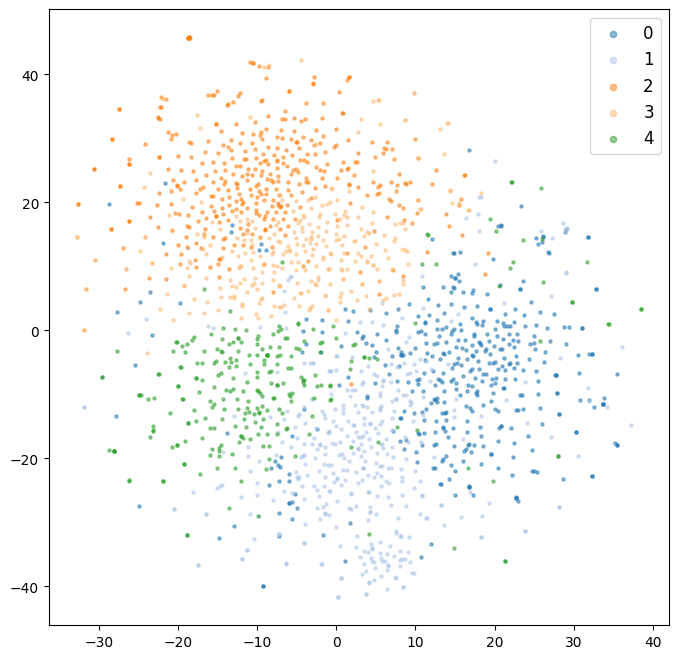

In [41]:
# Visualizing actual data using projection of embeddings

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
projected_data[['1', '2']].values.tolist()

tsne_proj = projected_data[['1', '2']].values
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
for lab in range(num_categories):
    indices = labels==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5,s=5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

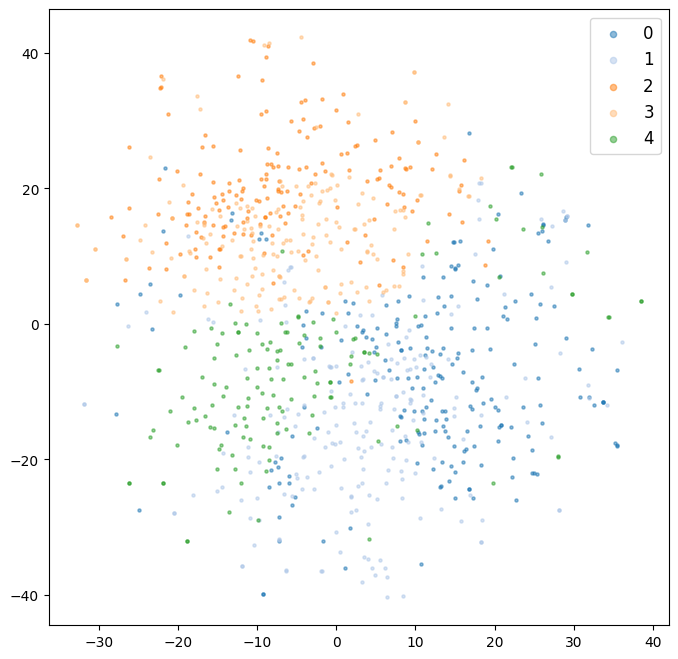

In [42]:
from sklearn.manifold import TSNE
from matplotlib import cm
import numpy as np

new_data = aflite_data
new_feats = feats[new_data.feats.values]
new_labels = new_data.labels
tsne_proj_new = tsne_proj[new_data.feats.values]
# tsne = TSNE(2, verbose=1)
# tsne_proj = tsne.fit_transform(new_feats)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
for lab in range(num_categories):
    indices = new_labels==lab
    ax.scatter(tsne_proj_new[indices,0],tsne_proj_new[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5,s=5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [43]:
removed_examples = list(set(range(len(data))) - set(aflite_data['feats'].values))

In [44]:
len(removed_examples)

860

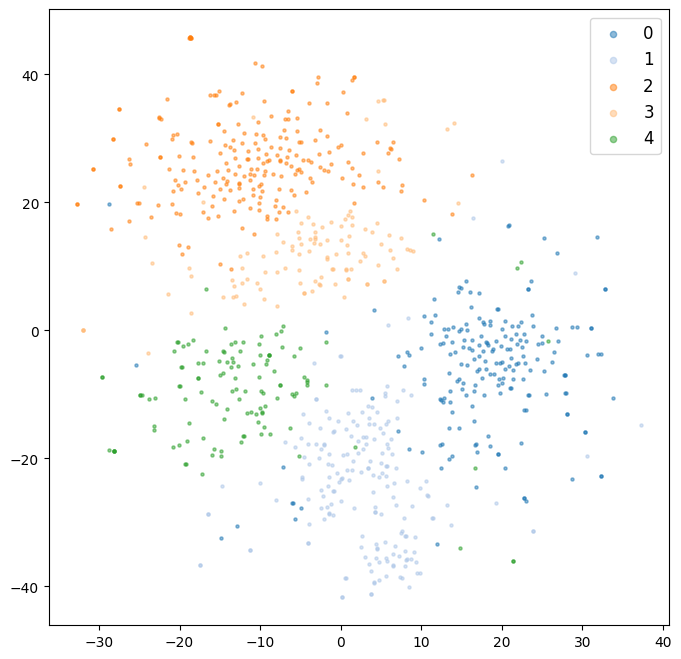

In [45]:
from sklearn.manifold import TSNE
from matplotlib import cm
import numpy as np

# data = aflite_data
new_feats = feats[removed_examples]
new_labels = data.iloc[removed_examples].labels
tsne_proj_new = tsne_proj[removed_examples]
# tsne = TSNE(2, verbose=1)
# tsne_proj = tsne.fit_transform(new_feats)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
for lab in range(num_categories):
    indices = new_labels==lab
    ax.scatter(tsne_proj_new[indices,0],tsne_proj_new[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5, s=5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [46]:
train_linear(feats[aflite_data['feats'].values], torch.tensor(aflite_data.labels.values))

'LINEAR acc: 0.6974 (+/-0.02)'

In [47]:
import numpy as np
import os
import pandas as pd

from matplotlib import pyplot as plt
from sklearn import svm, linear_model
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

random_ids = np.random.choice(range(len(data)), len(aflite_data), replace=False)
random_data = data.iloc[random_ids]

train_linear(feats[random_data['feats'].values], torch.tensor(random_data.labels.values))

'LINEAR acc: 0.8569 (+/-0.02)'

In [14]:
def accuracy(pred, ref):
    """Compute simple accuracy."""
    assert len(pred) == len(ref)
    correct = sum(pred == ref)
    return correct/len(ref)


def train_linear(x, y, num_seeds=10):
    """
    Splits data into train and test, and then trains a linear model on the 
    train, and with the trained model, computes accuracy 
    on the test set. Repeats the above `num_seeds` times, and returns the 
    mean / std of accuracies on the test set (to reduce variance).
    """
    acc = []
    for _ in range(num_seeds):
        train_data, test_data, train_label, test_label = train_test_split(x, y, test_size=0.33)

        
        lin = linear_model.SGDClassifier(max_iter=1000, 
                                         tol=1e-5)
        lin.fit(train_data, train_label)
        
        lin_predicted = lin.predict(test_data)
        acc.append(accuracy(torch.tensor(lin_predicted), test_label))
    return f"LINEAR acc: {np.mean(acc):.4f} (+/-{np.std(acc):.2f})"

In [33]:
len(data)

1786

In [34]:
len(set(aflite_data['feats'].values))

1191